## Read in the appropriate packages

In [ ]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import yfinance as yf
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Collect data around 3 US economic factors such as inflation, unemployment, etc. Explain why you think those variables will help in predicting stock prices. Mention source of data. Word Count - 200-500 words.**

I chose CPI(Consumer Price Index), which measures the price of a market basket of consumer goods and services, reflecting the inflation rate. I think high inflation rate can lead to customer's confidence decrease and unwillingness to spend and buy and company's profit loss, which negatively impact the stock price. The central bank is likely to increase interest rate to cooldown the economy, and high interest rate will increase the company's borrowing cost and lower profit, which also negatively impact stock price. A high inflation rate\
source: https://fred.stlouisfed.org/series/CPIAUCSL

I chose GEPUI(Global Economic Policy Uncertainty Index), which measures the uncertainty of the current policy in the world. A high political uncertainty can lead to risk aversion among investors and shift their money from stock to safer assets like bonds or gold. Uncertainty about future policies, taxes, or regulations can make companies cautious about spending on new projects or expansion, which negatively affect stock price.\
source: https://fred.stlouisfed.org/series/GEPUCURRENT

I chose Treasury Bill Interest Rate. A higher interest rate lead to higher cost of borrowing money. If a company has plan to borrow money to expand their businesses, the profit will be reduced due to the high cost of borrowing. Also investors may shift their money from stock market to treasury bills with higher return of investement, which will negatively affect stock price.\
source: https://fiscaldata.treasury.gov/datasets/average-interest-rates-treasury-securities/average-interest-rates-on-u-s-treasury-securities


In [ ]:
df_cpi = pd.read_csv("/content/drive/MyDrive/time_series/cpi.csv")
df_cpi['DATE'] = pd.to_datetime(df_cpi['DATE']).dt.strftime('%Y-%m')
df_cpi.rename(columns = {'CPIAUCSL':'cpi'}, inplace=True)
df_cpi

,DATE,cpi
0,1947-01,21.480
1,1947-02,21.620
2,1947-03,22.000
3,1947-04,22.000
4,1947-05,21.950
...,...,...
916,2023-05,303.294
917,2023-06,303.841
918,2023-07,304.348
919,2023-08,306.269


In [ ]:
df_uncertainty = pd.read_csv("/content/drive/MyDrive/time_series/gdp.csv")
df_uncertainty['DATE'] = pd.to_datetime(df_uncertainty['DATE']).dt.strftime('%Y-%m')
df_uncertainty = df_uncertainty.rename(columns = {'GEPUCURRENT':'global uncertainty'})
df_uncertainty

,DATE,global uncertainty
0,1997-01,78.118406
1,1997-02,80.388710
2,1997-03,70.176354
3,1997-04,75.094969
4,1997-05,73.538495
...,...,...
316,2023-05,227.639272
317,2023-06,230.391638
318,2023-07,227.380519
319,2023-08,212.781809


In [ ]:
df_interest = pd.read_csv("/content/drive/MyDrive/time_series/InterestRate.csv")
df_interest = df_interest[df_interest['Security Description']=='Treasury Bills']
df_interest = df_interest[['Record Date', 'Average Interest Rate Amount']]
df_interest = df_interest.reset_index().drop(columns = ['index'])
df_interest = df_interest.rename(columns = {'Record Date':'DATE', "Average Interest Rate Amount":"Treasury Bill Interest"})
df_interest['DATE'] = pd.to_datetime(df_interest['DATE']).dt.strftime('%Y-%m')
df_interest

,DATE,Treasury Bill Interest
0,2023-10,5.437
1,2023-09,5.380
2,2023-08,5.319
3,2023-07,5.219
4,2023-06,5.116
...,...,...
269,2001-05,4.560
270,2001-04,5.076
271,2001-03,5.369
272,2001-02,5.755


## 1. Download stock data - single and multiple and get it into the right format

A way of getting the historical stock data is to use the pandas_datareader library.
It uses Yahoo’s Finance API to load in the data.

### First, download SINGLE stock using pandas_datareader

In [ ]:
yf.pdr_override()

# Downloading SINGLE stock using pandas_datareader

stock_ticker = 'DIS'

stock_start_date = datetime.date(2010,1,1)
stock_end_date = datetime.date.today()

In [ ]:
# Fetch the stock price from Yahoo Finance
stock_df = pdr.get_data_yahoo(stock_ticker,start=stock_start_date,end=stock_end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
stock_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,32.500000,32.750000,31.870001,32.070000,27.933920,13700400
2010-01-05,32.070000,32.160000,31.700001,31.990000,27.864239,10307700
2010-01-06,31.900000,32.000000,31.680000,31.820000,27.716164,10709500
2010-01-07,31.770000,31.860001,31.540001,31.830000,27.724874,8202100
2010-01-08,31.660000,31.940001,31.530001,31.879999,27.768421,7657500
...,...,...,...,...,...,...
2023-11-03,84.169998,85.930000,84.160004,85.070000,85.070000,11322700
2023-11-06,85.080002,85.800003,83.589996,84.019997,84.019997,14160900
2023-11-07,84.160004,84.680000,83.949997,84.589996,84.589996,10540200


## **monthly median**

In [ ]:
df_stock_month = stock_df.resample('M').median()
df_stock_month = pd.DataFrame(df_stock_month['Close'])
df_stock_month.index = df_stock_month.index.strftime('%Y-%m')
df_stock_month

,Close
Date,
2010-01,31.010000
2010-02,30.469999
2010-03,33.750000
2010-04,36.220001
2010-05,34.035000
...,...
2023-07,87.639999
2023-08,85.959999
2023-09,81.610001


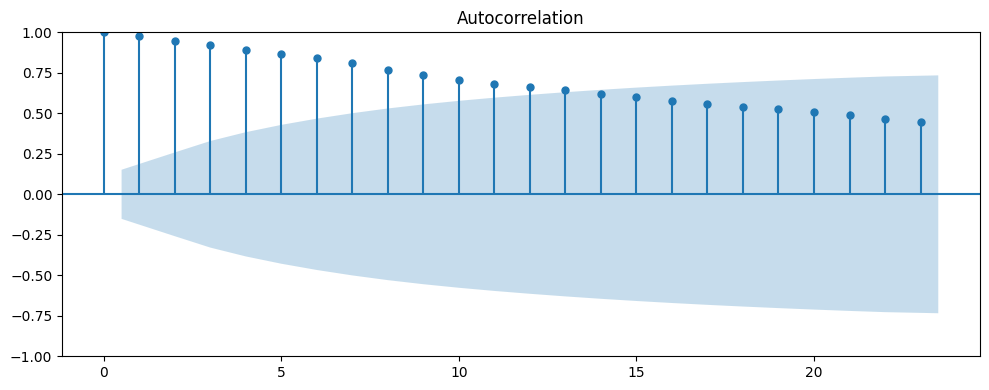

In [ ]:
fig = plot_acf(df_stock_month)
fig.set_size_inches((10, 4))
# Tight layout to realign things
fig.tight_layout()
plt.show()

## **merge datasets**

In [ ]:
df = df_stock_month.merge(df_cpi, left_on = 'Date', right_on = 'DATE', how = 'inner')
df = df.merge(df_uncertainty, on='DATE', how = 'inner')
df = df.merge(df_interest, on='DATE', how='inner')
df.index = df['DATE']
df = df.drop(columns = 'DATE')
df

,Close,cpi,global uncertainty,Treasury Bill Interest
DATE,,,,
2010-01,31.010000,217.488,112.011239,0.238
2010-02,30.469999,217.281,110.692733,0.227
2010-03,33.750000,217.353,106.457392,0.227
2010-04,36.220001,217.403,102.701460,0.234
2010-05,34.035000,217.290,147.122159,0.241
...,...,...,...,...
2023-05,92.539997,303.294,227.639272,4.991
2023-06,90.769997,303.841,230.391638,5.116
2023-07,87.639999,304.348,227.380519,5.219


## **Serial Correlation**

<Axes: >

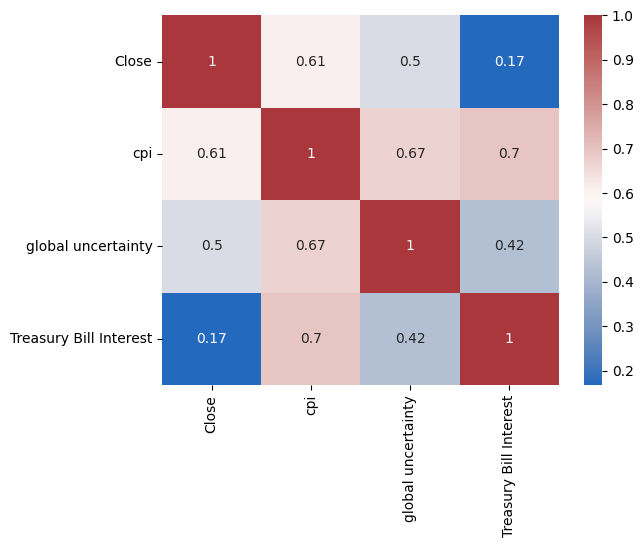

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap = 'vlag')

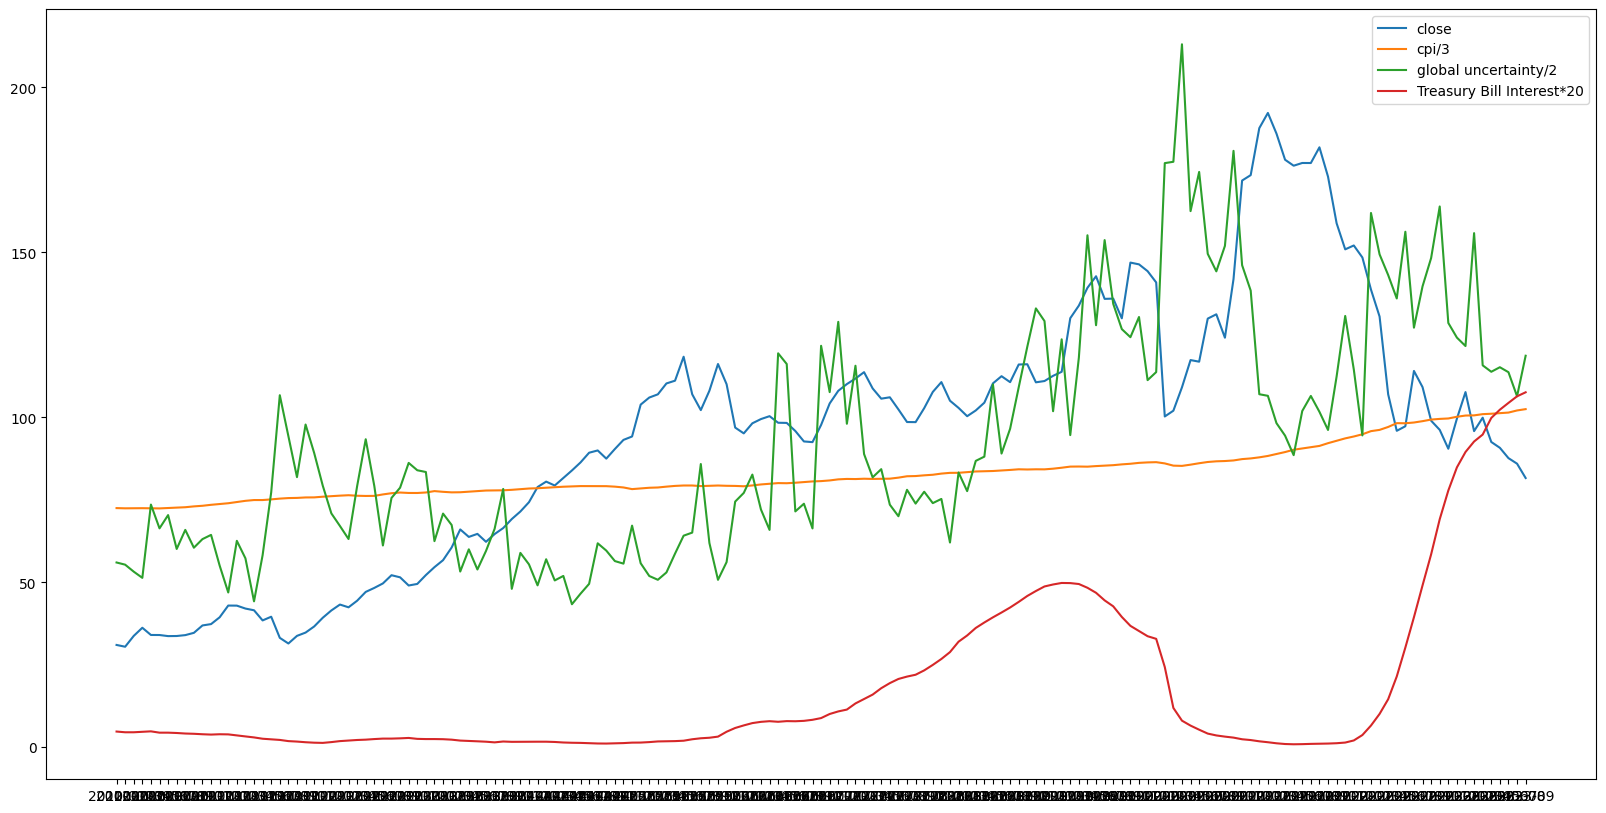

In [ ]:
ax, fig = plt.subplots(1,1, figsize = (20,10))
plt.plot(df['Close'], label = 'close')
plt.plot(df['cpi']/3, label = 'cpi/3')
plt.plot(df['global uncertainty']/2, label = 'global uncertainty/2')
plt.plot(df['Treasury Bill Interest']*20, label = 'Treasury Bill Interest*20')
plt.legend()

### **high serial correlation is caused by the rising trends. We have to detrend before calculating the actual correlation**

## **Correlation after removing trend**

In [ ]:
df_diff = df.diff()[1:]
df_diff

,Close,cpi,global uncertainty,Treasury Bill Interest
DATE,,,,
2010-02,-0.540001,-0.207,-1.318505,-0.011
2010-03,3.280001,0.072,-4.235341,0.000
2010-04,2.470001,0.050,-3.755933,0.007
2010-05,-2.185001,-0.113,44.420699,0.007
2010-06,-0.014999,-0.091,-14.418591,-0.020
...,...,...,...,...
2023-05,-7.360004,0.376,-3.896823,0.252
2023-06,-1.770000,0.547,2.752366,0.125
2023-07,-3.129997,0.507,-3.011119,0.103


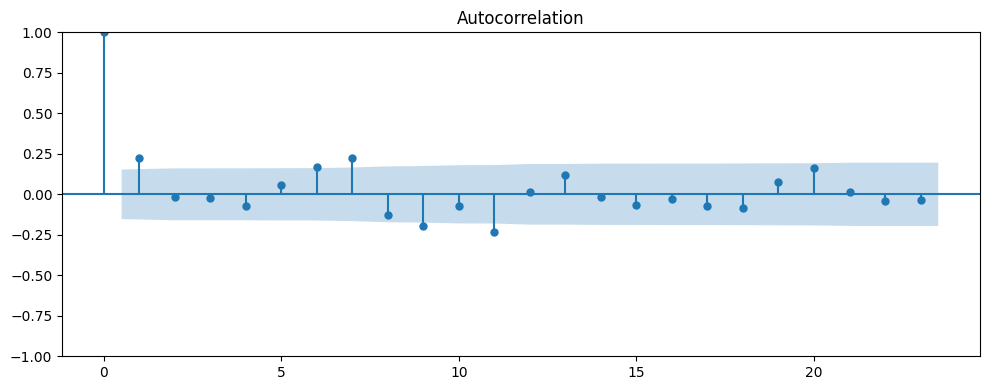

In [ ]:
fig = plot_acf(df_diff['Close'])
fig.set_size_inches((10, 4))
# Tight layout to realign things
fig.tight_layout()
plt.show()

<Axes: >

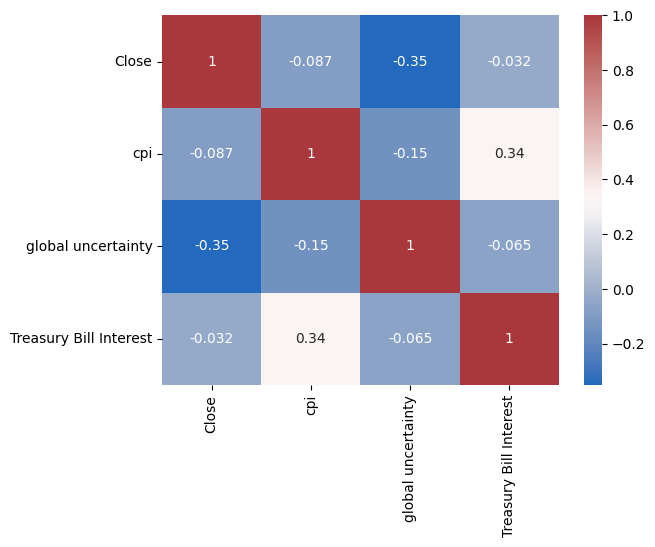

In [ ]:
sns.heatmap(df_diff.corr(), annot=True, cmap = 'vlag')

**After we detrend the time series, we can get the actual correlation between stock and the three economic indicators. We can see that the stock is slightly negatively correlated with CPI, -0.087, and a larger negative correlation with global uncertainty, about -0.35. And a very small correlation with Treasury Bill Interest, -0.032. Uncertainty seemes to be good predictor, other two are bad.**

## Split data into train and test sets

In [ ]:
from sklearn.model_selection import train_test_split
mcd = df[['Close']]
mcd.index = pd.to_datetime(mcd.index)
# Create a test set of 12 data points
test_size = 12
train_data, test_data = train_test_split(mcd, test_size=test_size, random_state=25, shuffle = False)
print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 153
No. of testing examples: 12


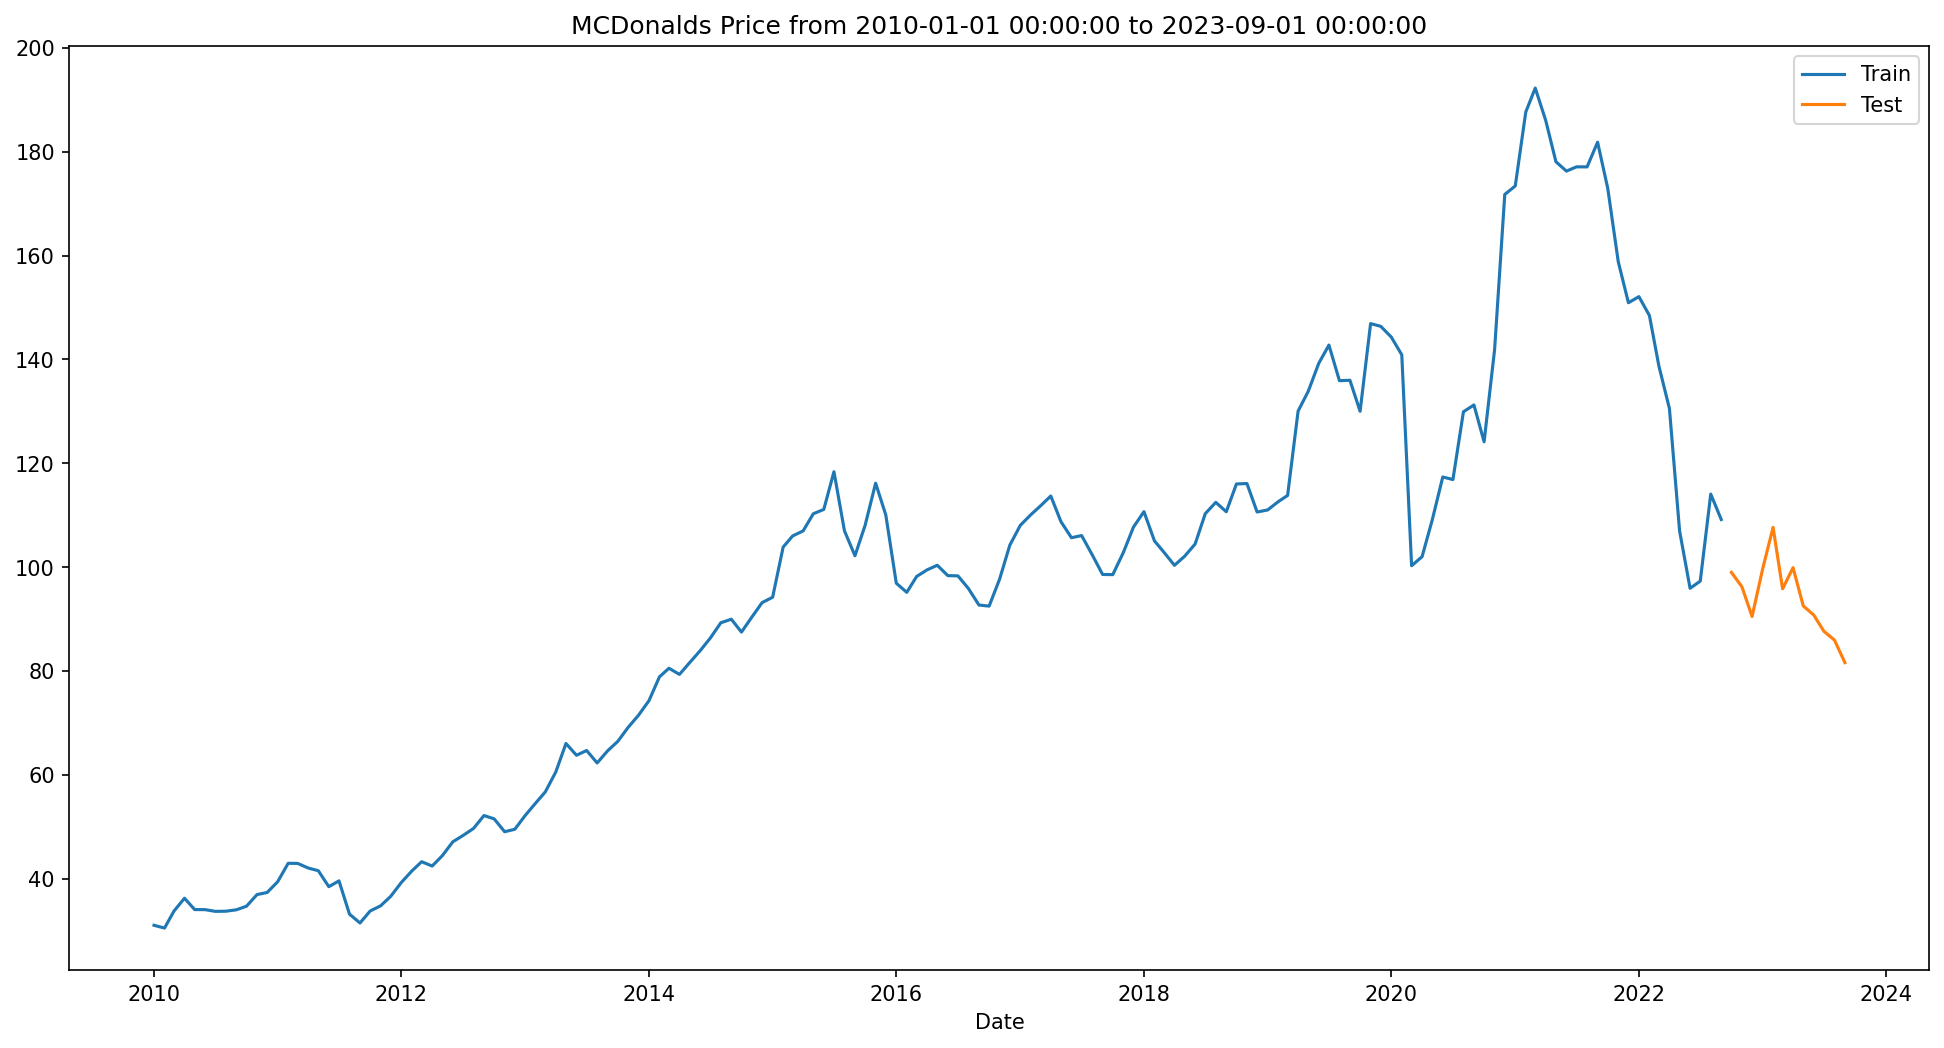

In [ ]:
plt.figure(figsize=(16, 8), dpi=150)
plt.plot(train_data,label='Train')
plt.plot(test_data,label='Test')
stock_start_date = train_data.index[0]
stock_end_date = test_data.index[-1]
# adding title to the plot
plt.title('MCDonalds Price from {} to {}'.format(stock_start_date, stock_end_date))
# adding Label to the x-axis
plt.xlabel('Date')
# adding legend to the curve
plt.legend()

## Fitting Models - Exponential Smoothing Models

### ETS - Error, Trend, Seasonailty

#### Simple Exponential Smoothing

The simplest of the exponentially smoothing methods is naturally called simple exponential smoothing (SES). This method is suitable for forecasting data with no clear trend or seasonal pattern.

In [ ]:
#First Instance
ins1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2,optimized=False)
ins_cast1 = ins1.forecast(12).rename('alpha=0.2')

#Second Instance
ins2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.5,optimized=False)
ins_cast2 = ins2.forecast(12).rename('alpha=0.5')

#Third Instance
ins3 = SimpleExpSmoothing(train_data).fit()
ins_cast3 = ins3.forecast(12).rename('alpha=%s'%ins3.model.params['smoothing_level'])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
ins_cast1

2022-10-01    120.697053
2022-11-01    120.697053
2022-12-01    120.697053
2023-01-01    120.697053
2023-02-01    120.697053
2023-03-01    120.697053
2023-04-01    120.697053
2023-05-01    120.697053
2023-06-01    120.697053
2023-07-01    120.697053
2023-08-01    120.697053
2023-09-01    120.697053
Freq: MS, Name: alpha=0.2, dtype: float64

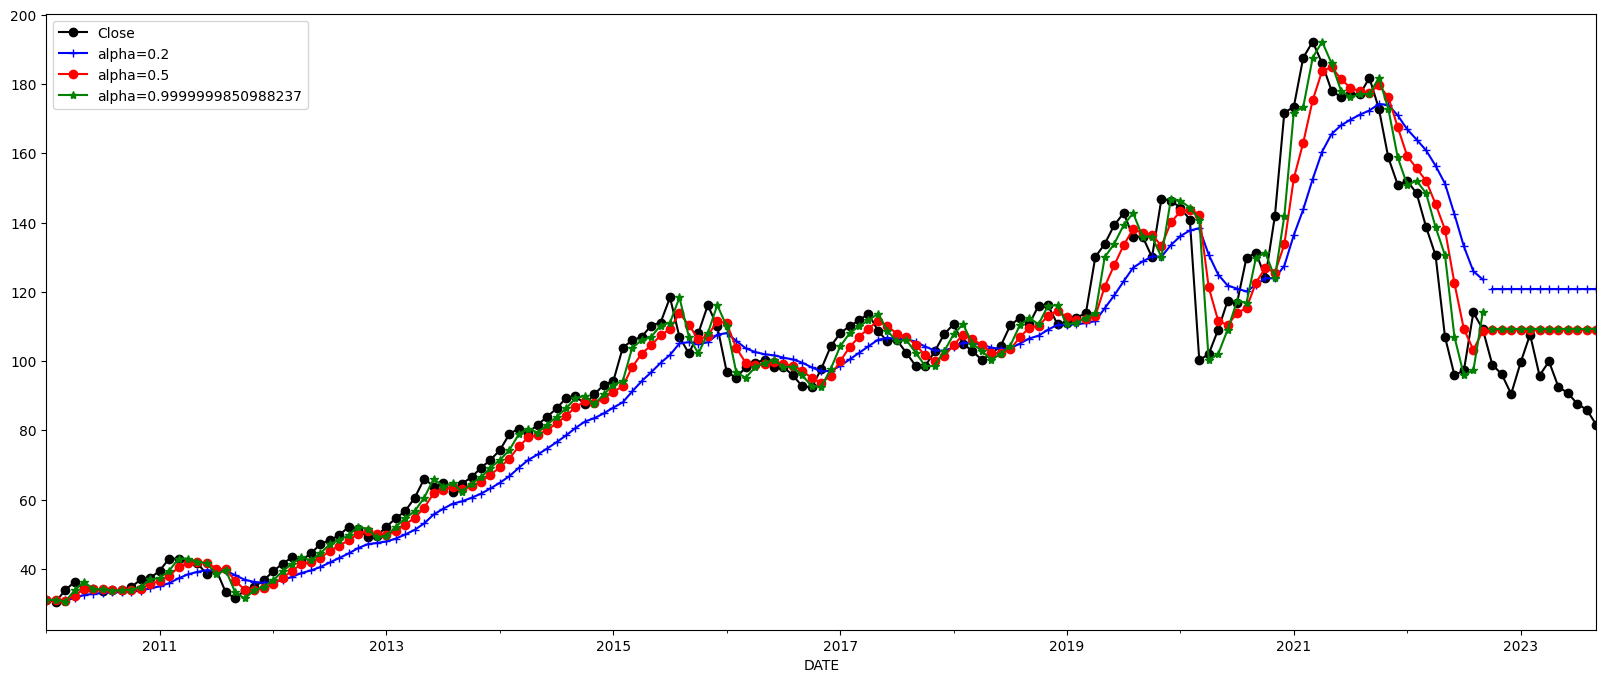

In [ ]:
#After creating model we will visualize the plot
#After creating model we will visualize the plot
ax = mcd.plot(marker='o', color='black', figsize=(20,8), legend=True)

# #Plot for alpha =0.2
ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for alpha = 0.5
ins_cast2.plot(marker='o', ax=ax, color='red', legend=True)
ins2.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

**Statsmodel put alpha=1 as the best, which means it thinks using yesterday's actual price as the forecasting is the best. The error of Alpha=0.5, 1 are lower, and 0.2 is higher because it put too much weight on the past which is bad on this graph.**

#### Double Exponential Smoothing

This is the extended version of simple exponential smoothing to allow the forecasting of data with a trend. This method has two smoothing equations and hence two parameters, alpha and beta, (one for the level and one for the trend).

In [ ]:
double_ets_add = ExponentialSmoothing(train_data, trend = 'add').fit()
double_ets_mul = ExponentialSmoothing(train_data, trend = 'mul').fit()

double_ets_add_pred = double_ets_add.forecast(12)
double_ets_mul_pred = double_ets_mul.forecast(12)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


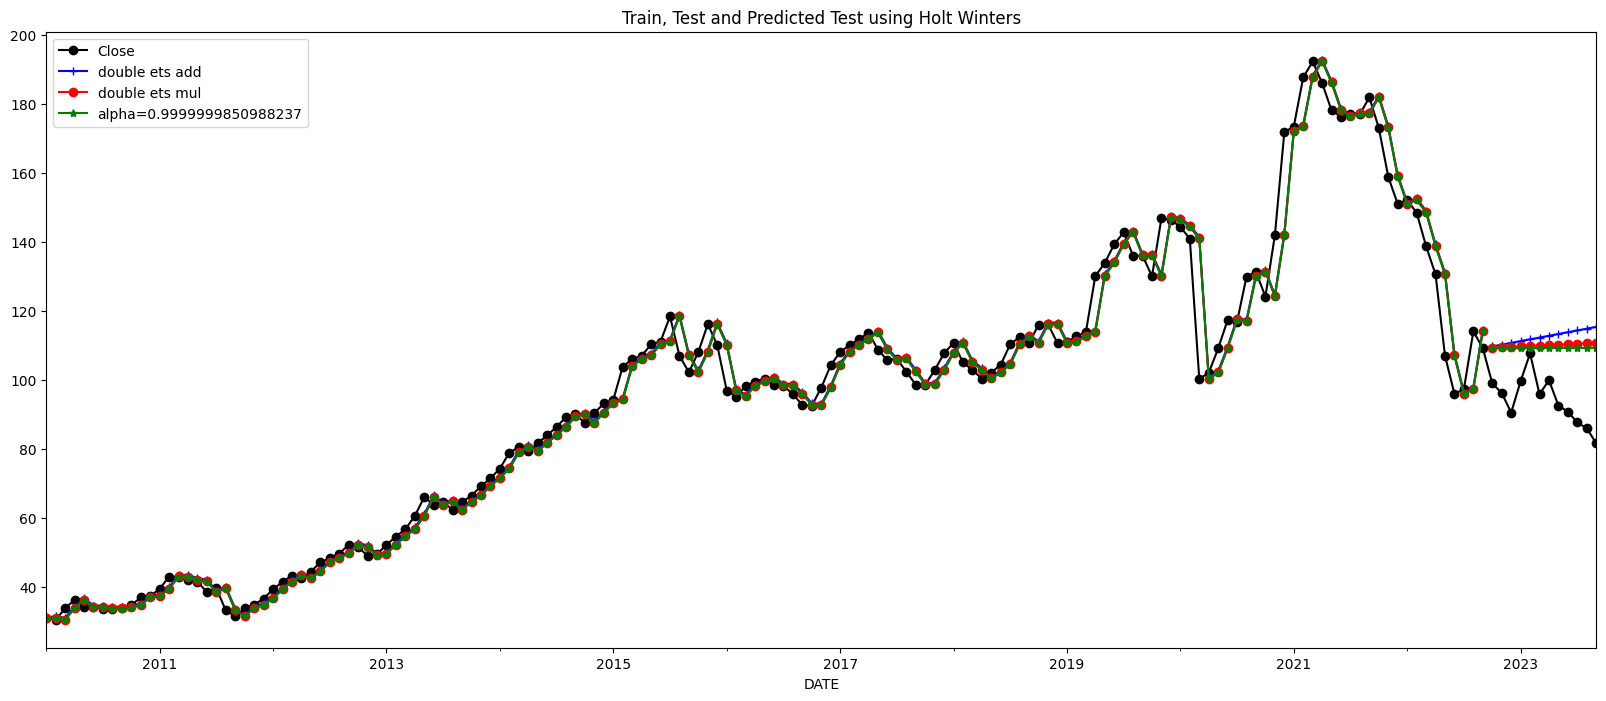

In [ ]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = mcd.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'double ets add')
double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

# Plot for double ETS multiplicative
double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'double ets mul')
double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()



**The trend is added but off**

#### Triple Exponential Smoothing

This is the extended version of simple exponential smoothing to allow the forecasting of data with a trend and seasonality. This method has three smoothing equations and hence three parameters - alpha, beta, and gamma. (one each for the level, trend, and seasonality).

In [ ]:
# triple ETS - Holt Winter's Seasonal Method
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


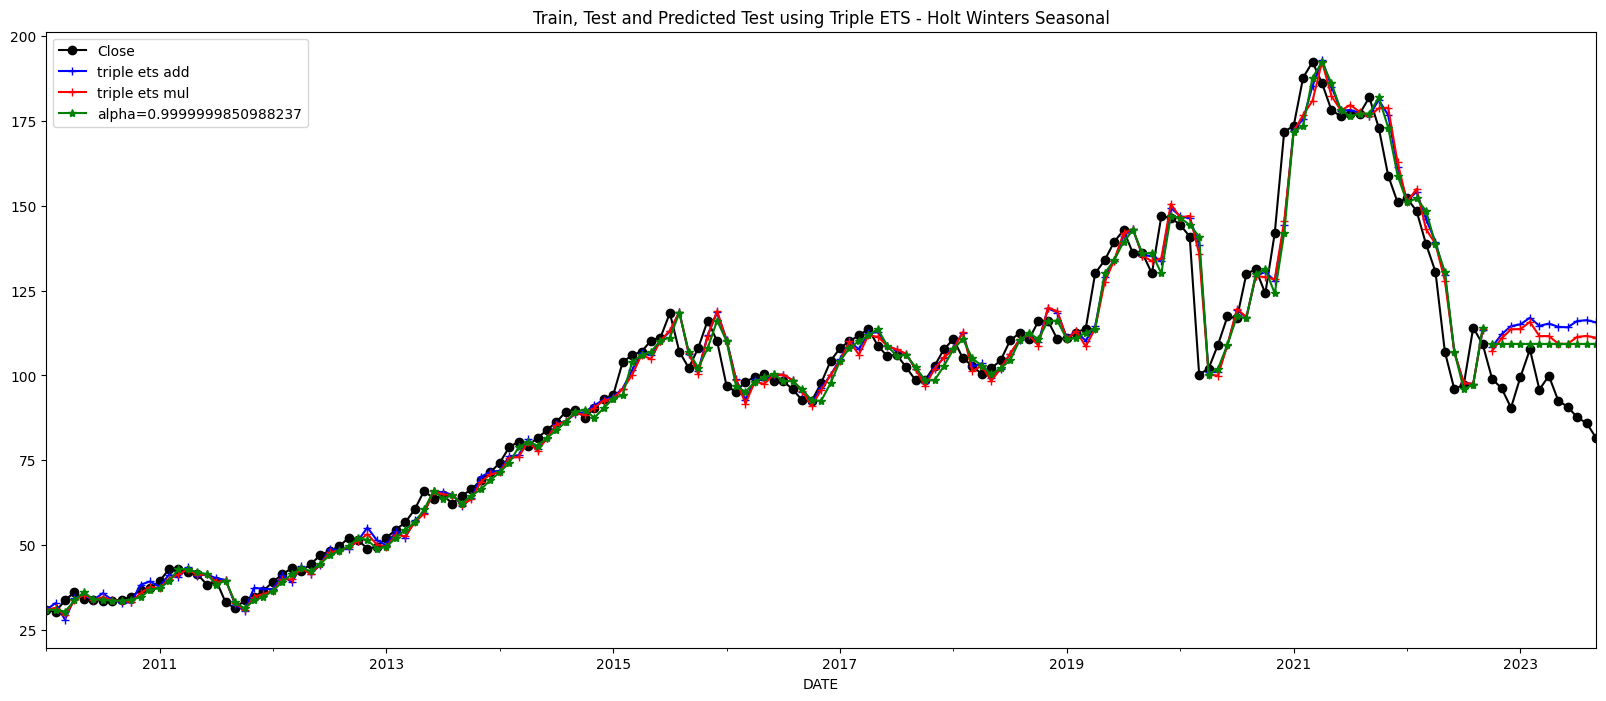

In [ ]:
from IPython.core.prefilter import MagicHandler
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = mcd.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
triple_ets_mul_pred.plot(marker='+', ax=ax, color='red', legend=True, label = 'triple ets mul')
triple_ets_mul.fittedvalues.plot(marker='+', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

**Seasonality added, looks better**

## Visualize Forecast Errors

Source: https://machinelearningmastery.com/visualize-time-series-residual-forecast-errors-with-python/

In [ ]:
# Residual Plots / Residual Diagnostics. What are residuals?

In [ ]:
#calculate residuals, triple ets
residuals = [test_data.values.flatten()[i]-triple_ets_add_pred.values.flatten()[i] for i in range(len(test_data))]
residuals = pd.DataFrame(residuals)

In [ ]:
residuals

,0
0,-9.409326
1,-15.907765
2,-24.052878
3,-15.440976
4,-9.332246
5,-18.773696
6,-15.369022
7,-21.759561
8,-23.407900
9,-28.387633


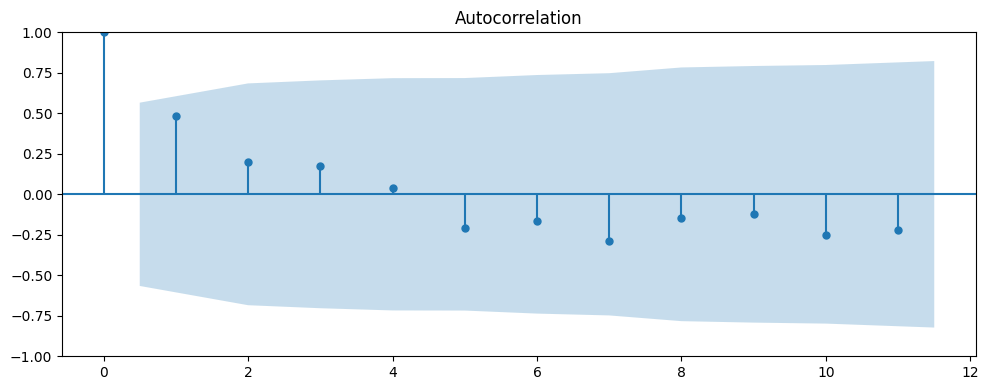

In [ ]:
fig = plot_acf(residuals)
fig.set_size_inches((10, 4))
# Tight layout to realign things
fig.tight_layout()
plt.show()

### Metrics - model evaluation

1. Root Mean Squared Error (RMSE) represents the sample standard deviation of the differences between predicted values and observed values. These individual differences are called residuals when the calculations are performed over the data sample that was used for estimation, and are called prediction errors when computed out-of-sample. This is a great measurement to use when comparing models as it shows how many deviations from the mean the forecasted values fall.
2. Mean Absolute Error (MAE) takes the sum of the absolute difference from actual to forecast and averages them. It is less sensitive to the occasional very large error because it does not square the errors in the calculation.
3. Mean Absolute Percentage Error (MAPE) is also often useful for purposes of reporting, because it is expressed in generic percentage terms it will make sense even to someone who has no idea what constitutes a "big" error in terms of dollars spent or widgets sold.

In [ ]:
#define metrics dataframe which will be used below for
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])
from sklearn.metrics import r2_score

def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    correlation = np.corrcoef(actuals, predictions)[0,1]
    r2 = r2_score(actuals, predictions)


    df = pd.DataFrame({'Model': model,
                       'RMSE': rmse,
                       'MAE': mae,
                       'MAPE': mape,
                       'Corr': correlation,
                       'R2': r2
                       }, index=[0])
    dataframe = metrics_dataframe.append(df)
    return dataframe

In [ ]:
#get all the metrics
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast1.values.flatten(),
                                'Simple 0.2')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast2.values.flatten(),
                                'Simple 0.5')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast3.values.flatten(),
                                'Simple 1')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_add_pred.values.flatten(),
                                'Double Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_mul_pred.values.flatten(),
                                'Double Mul')


metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_add_pred.values.flatten(),
                                'Triple Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_mul_pred.values.flatten(),
                                'Triple Mul')


<ipython-input-241-edbdd9dea46f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
<ipython-input-241-edbdd9dea46f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
<ipython-input-241-edbdd9dea46f>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = metrics_dataframe.append(df)
<ipython-input-241-edbdd9dea46f>:21: FutureWarning: The frame.app

In [ ]:
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE,Corr,R2
0,Simple 0.5,16.489495,14.981798,16.576164,-6.876772e-16,-4.730415
0,Simple 1,16.721018,15.236249,16.848512,NaN,-4.892462
0,Double Mul,17.614669,16.075643,17.771984,-6.821979e-01,-5.539135
0,Triple Mul,18.666953,17.484900,19.208968,3.152774e-01,-6.343756
0,Double Add,20.314387,18.584223,20.531439,-6.813551e-01,-7.697186
0,Triple Add,21.866715,20.514485,22.534102,-1.707644e-01,-9.077167
0,Simple 0.2,27.635549,26.763303,29.186326,6.876772e-16,-15.095613


**I chose pearson correlation coefficient to measure how often the prediction and actual move price together or separate. And R2 to see how much variation we explained by our model, but negative r2 does not tell us very much information. From the above charts simple 0.5 and simple 1 have lower MAE, RMSE, and MAPE, but their correlation coefficient is very low, it gives 0 correlation and NaN correlation(due to zero variance in the divider), which does not serve as good forecasting. I think Triple Mul is the best in comparison, it has relatively low MAE, RMSE, and MAPE, not the lowest but very importantly, a positive correlation 0.315, which is a pretty high correlation coefficient with the actual price. We can also see from the graph, the prediction has a similar flow with the actual price.**